## import modules

In [1]:
import numpy as np
import pandas as pd

from scipy import interpolate

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.model_selection import train_test_split

from modules.layers import hamming_layer, maxnet_layer
from modules.HammingNN import Hamming_NN

## import data

In [2]:
# Forgor how to choose dimensions for reshape, but I will change 
# do something about this next time I'll use this code... No promise tho 
def show(array, n, m, size = (10, 5)):
    fig, axs = plt.subplots(n,m, figsize=size)
    array_to_plot = array.reshape((n, m) + array.shape[1:])
    for i in range(n):
        for j in range(m):
            axs[i,j].imshow(array_to_plot[i,j], cmap='Greys', )
            axs[i,j].title.set_text((i*m) + j)

In [3]:
from sklearn.datasets import load_digits

def examples_sum(X, num_target, threshold = 0.5):
    examples = []
    for i in range(num_target):
        temp = np.sum(X_train[y_train == i], axis = 0)
        temp = temp / temp.max()
        examples.append(temp >= threshold)
    return np.array(examples)

digits = load_digits()

X = digits.data / digits.data.max(axis = 1, keepdims = True) >=0.5
Y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

# E = np.load('digits.npy').reshape(-1, 64)
E = examples_sum(X_train, np.unique(Y).shape[0], 0.6)

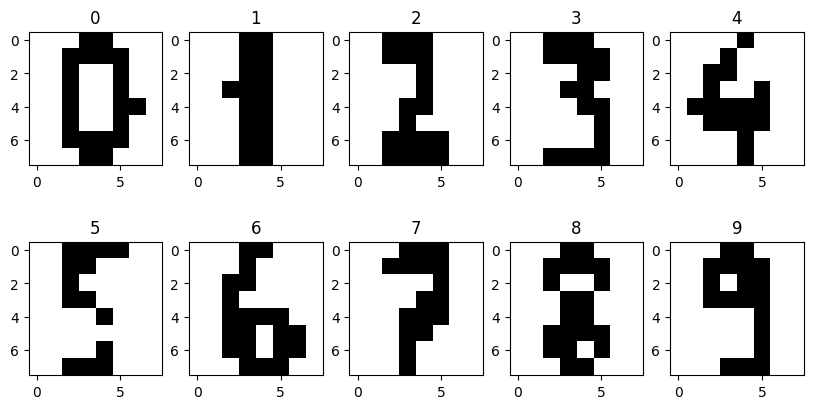

In [4]:
show(E.reshape(-1,8,8), 2, 5)

## Creating a model

In [8]:
M, N = E.shape

max_iter = 100
        
# activation functions:
# ls, relu, sgelu, ssilu, smish
layers = [
    hamming_layer(N, M, activation="ls"),
    maxnet_layer(M, M, activation="ls"),
]

model = Hamming_NN(layers, E, pt = .2)

model.predict_class_separated(X_test, y_test, max_iter)[0]

array([1.        , 0.45238095, 0.83870968, 0.70967742, 0.63636364,
       0.14634146, 0.89285714, 0.8       , 0.88888889, 0.48484848])

# Testing

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


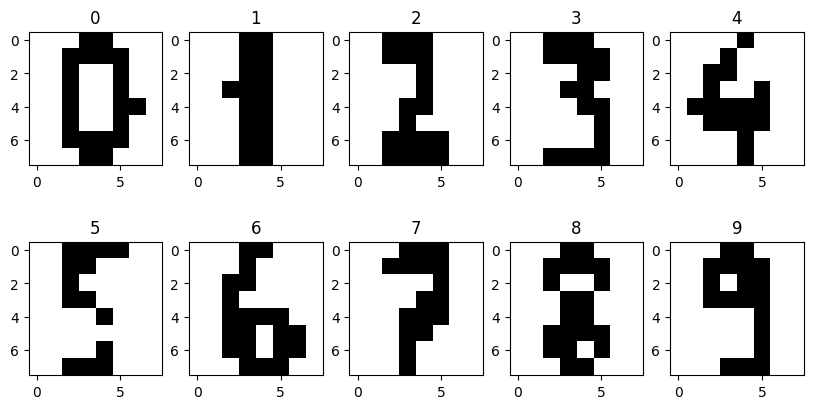

In [9]:
print(model.predict_class_separated(E, np.arange(10), max_iter)[0])
show(E.reshape(-1, 8, 8), 2, 5)

In [10]:
X_test.shape

(360, 64)

<Axes: ylabel='count'>

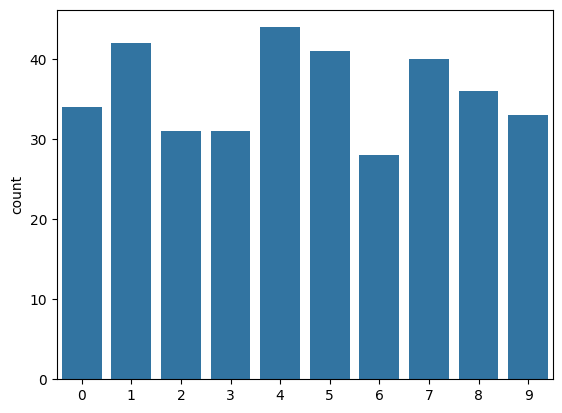

In [11]:
# for i in range(10):
#     print(f"num of {i}: {len(X_test[y_test == i])}")

sns.countplot(x = y_test)

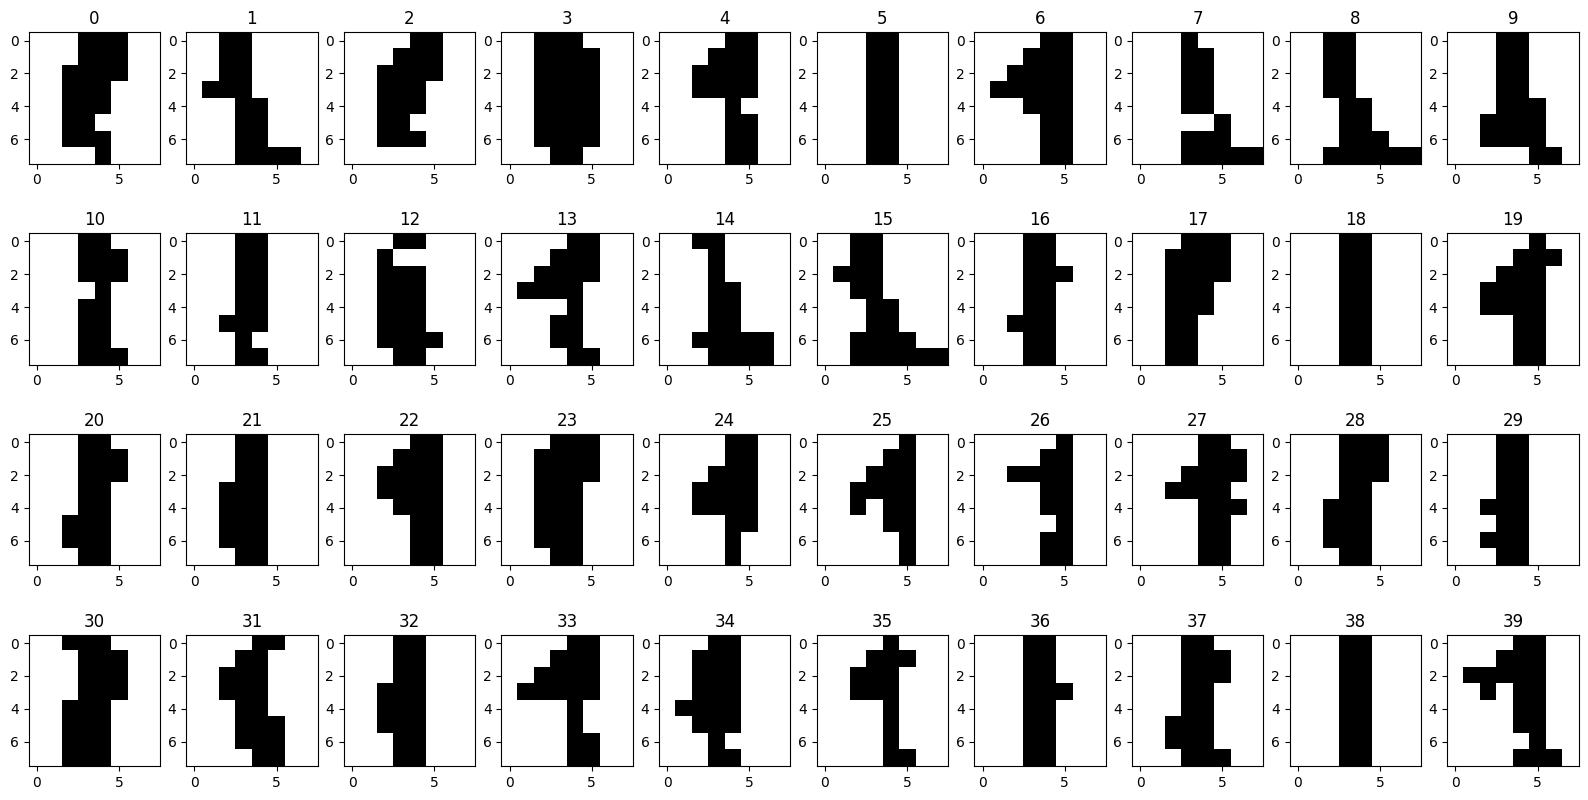

In [12]:
show(X_test[y_test == 1][:40].reshape(-1, 8, 8), 4, 10, size = (20,10))

In [13]:
model.predict_class_separated(X_test, y_test, max_iter)[1]

array([34, 19, 26, 22, 28,  6, 25, 32, 32, 16])

# Errors on noised and vanished data

## Functions for data processing 

In [14]:
def vanish(array, percent):
    array_copy = array.copy()
    indexes = np.random.choice(2, size = array_copy.shape, p = [1 - percent, percent])
    array_copy[indexes == 1] = 0
    return array_copy

def noise(array, percent):
    array_copy = array.copy()
    indexes = np.random.choice(2, size = array_copy.shape, p = [1 - percent, percent])
    array_copy[indexes == 1] = 1
    return array_copy

### processing data

In [15]:
E_noise = noise(E, .2)
E_vanish = vanish(E, .2)

### visualizing of the results on the training examples

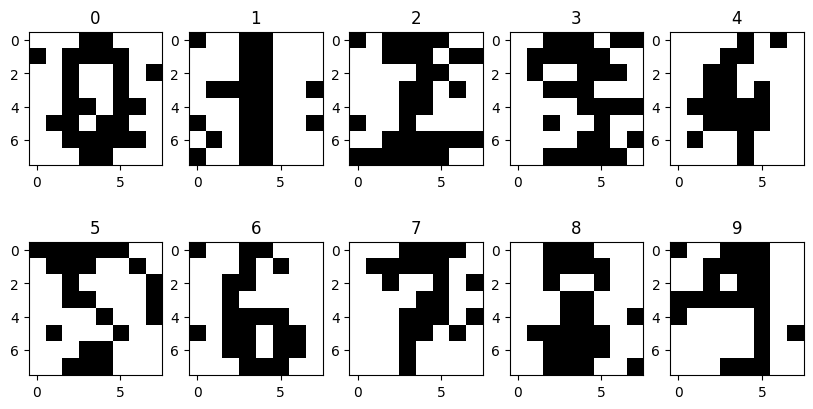

In [16]:
show(E_noise.reshape(-1, 8, 8), 2, 5)

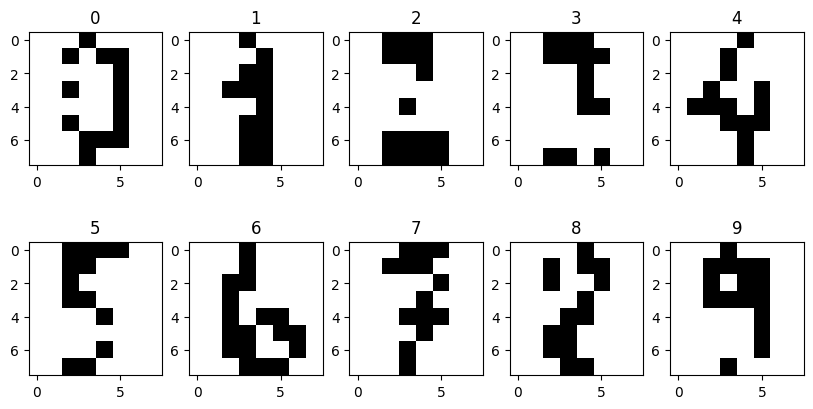

In [17]:
show(E_vanish.reshape(-1, 8, 8), 2, 5)

## calculating mean error of the model depending on the noise/vanishing level

In [18]:
mean_vanished_error = []
mean_noised_error = []
for percent in np.arange(0.005, 1.005, 0.005):
    noised_error = 1 - model.predict_class_separated(vanish(X_test, percent), y_test, max_iter)[0]
    vanished_error = 1 - model.predict_class_separated(noise(X_test, percent), y_test, max_iter)[0]
    mean_noised_error.append(np.mean(noised_error))
    mean_vanished_error.append(np.mean(vanished_error))

### Graph of the results

In [19]:
x_c = np.arange(0.005, 1.005, 0.005)
tck = interpolate.splrep(x_c, mean_noised_error, k = 3, s = 0.08)
mean_noised_error_smoothed = interpolate.splev(x_c, tck, der = 0)

tck = interpolate.splrep(x_c, mean_vanished_error, k = 3, s = 0.04)
mean_vanished_error_smoothed = interpolate.splev(x_c, tck, der = 0)


data = [
    go.Scatter(x = x_c*100, y = mean_noised_error_smoothed*100, name = 'mean noised error'),
    go.Scatter(x = x_c*100, y = mean_vanished_error_smoothed*100, name = 'mean vanished error'),

]

layout = go.Layout(
    height = 1000,
    title = dict(
        text = 'Mean error of the Methods',
        font_size = 30,
        x = .5
    ),
    xaxis=dict(ticksuffix="%"),
    xaxis_title = dict(
        text = 'Noise level [%]',
        font_size = 20
    ),
    yaxis=dict(ticksuffix="%"),
    yaxis_title = dict(
        text = 'Percentage of error, [%]',
        font_size = 20
    ),
    legend = dict(
        x = 0.02, y = .98,
        bgcolor = 'rgba(0,0,0,0)',
        font_size = 20
    ),
    margin={'r':0}
)
go.Figure(data, layout)

## Fixed noise and vanishing level

In [20]:
noised_error = 1 - model.predict_class_separated(vanish(X_test, 0.2), y_test, max_iter)[0]
vanished_error = 1 - model.predict_class_separated(noise(X_test, 0.2), y_test, max_iter)[0]

In [21]:
data = [
    go.Bar(x = np.arange(10), y = noised_error*100, name = 'noised error'),
    go.Bar(x = np.arange(10), y = vanished_error*100, name = 'vanished error'),
]

layout = go.Layout(
    barmode='group',
    height = 500,
    title = dict(
        text = 'Error with fixed levels of noise and vanishing',
        font_size = 30,
        x = .5
    ),
    xaxis = dict(nticks = 11),
    xaxis_title = dict(
        text = 'Number',
        font_size = 20
    ),
    yaxis=dict(ticksuffix="%"),
    yaxis_title = dict(
        text = 'Percentage of error, [%]',
        font_size = 20
    ),
)
go.Figure(data, layout)

# Testing on the mnist data

In [22]:
data = pd.read_csv("train.csv").to_numpy()
Y_28 = data[:, 0]
X_28 = data[:, 1:] / 255.

E_28 = np.load('digits_upscaled.npy').reshape(-1, 784)

In [23]:
M, N = E_28.shape
        
# activation functions:
# ls, relu, sgelu, ssilu, smish
layers = [
    hamming_layer(N, M, activation="sgelu"),
    maxnet_layer(M, M, activation="sgelu"),
]

model = Hamming_NN(layers, E_28)

predictions = model.predict_class_separated(X_28, Y_28, max_iter)[0]

print(predictions)

print(f'mean error {np.mean(1 - predictions)*100:.2f}%')

[0.00096805 0.43744663 0.15968398 0.00758446 0.30918468 0.00395257
 0.17186367 0.0204499  0.09229633 0.00095511]
mean error 87.96%


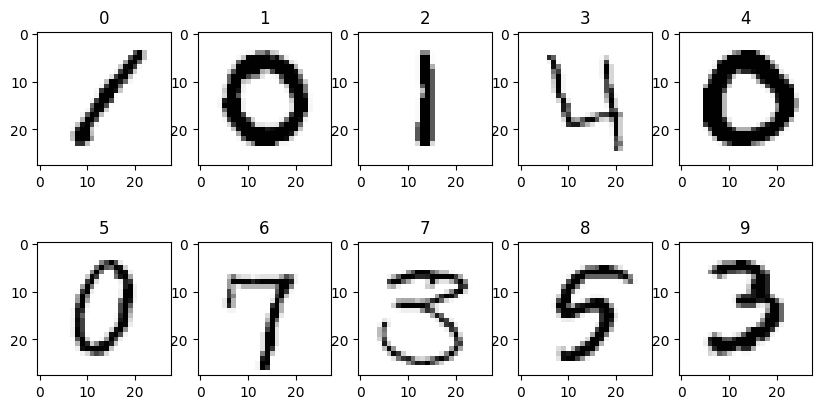

In [24]:
show(X_28[:10].reshape(-1, 28, 28), 2,5)

In [25]:
data = [
    go.Bar(x = np.arange(10), y = (1 - predictions)*100),
]

layout = go.Layout(
    height = 500,
    title = dict(
        text = 'Error on each mnist number',
        font_size = 30,
        x = .5
    ),
    xaxis = dict(nticks = 11),
    xaxis_title = dict(
        text = 'Number',
        font_size = 20
    ),
    yaxis=dict(ticksuffix="%"),
    yaxis_title = dict(
        text = 'Percentage of error, [%]',
        font_size = 20
    ),
)
go.Figure(data, layout)